# Airborne electromagnetic data inversion with `SimPEG`
## Application to the `ANTAEM` project airborne EM resistivity data from the McMurdo Region, Antarctica.
> Tyler Petillion

-----


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Start with just importing the time domain module of simpeg, and a utility to plot a layered model.
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG.utils import plot_1d_layer_model
import discretize

import contextily as ctx


savefig = True

## Load and process the data to be inverted
-----

In [31]:
# load in data
data_directory = '../usapdc_601373/SkyTEM2018_dat.xyz'
data_file = pd.read_csv(data_directory, skiprows=11, sep='\s+', escapechar='/')

# trim white space from first column
data_file.columns = data_file.columns.str.strip()

# print out dataframe
data_file

,LINE_NO,UTMX,UTMY,RECORD,ELEVATION,ALT,NUMDATA,SEGMENT,DATA_1,DATA_2,...,DATASTD_31,DATASTD_32,DATASTD_33,DATASTD_34,DATASTD_35,DATASTD_36,DATASTD_37,DATASTD_38,DATASTD_39,DATASTD_40
0,1101,541450.6,1356342.9,9,-53.5,67.92,9,1,4.029200e-11,3.002900e-11,...,99999.00,99999.00,99999.00,99999.00,99999.00,99999.0000,99999.0000,99999.0000,99999.0000,99999.0000
1,1101,541450.6,1356342.9,9,-53.5,67.92,23,2,9.999900e+04,9.999900e+04,...,0.03,0.03,0.03,0.03,0.03,0.0301,0.0301,0.0301,0.0302,0.0304
2,1101,541485.6,1356349.6,10,-53.6,91.00,10,1,3.453200e-11,2.617500e-11,...,99999.00,99999.00,99999.00,99999.00,99999.00,99999.0000,99999.0000,99999.0000,99999.0000,99999.0000
3,1101,541485.6,1356349.6,10,-53.6,91.00,23,2,9.999900e+04,9.999900e+04,...,0.03,0.03,0.03,0.03,0.03,0.0300,0.0301,0.0301,0.0302,0.0304
4,1101,541520.3,1356359.7,11,-53.5,92.01,11,1,3.906400e-11,3.850900e-11,...,99999.00,99999.00,99999.00,99999.00,99999.00,99999.0000,99999.0000,99999.0000,99999.0000,99999.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63213,28030,471477.0,1405180.8,40328,-53.6,59.05,23,2,9.999900e+04,9.999900e+04,...,0.03,0.03,0.03,0.03,0.03,0.0300,0.0300,0.0301,0.0310,0.0352
63214,28030,471458.5,1405228.2,40329,-53.5,58.74,17,1,1.817300e-10,1.596800e-10,...,99999.00,99999.00,99999.00,99999.00,99999.00,99999.0000,99999.0000,99999.0000,99999.0000,99999.0000
63215,28030,471458.5,1405228.2,40329,-53.5,58.74,23,2,9.999900e+04,9.999900e+04,...,0.03,0.03,0.03,0.03,0.03,0.0300,0.0300,0.0301,0.0302,0.0308
63216,28030,471438.1,1405275.2,40330,-53.5,48.87,17,1,1.926900e-10,1.656100e-10,...,99999.00,99999.00,99999.00,99999.00,99999.00,99999.0000,99999.0000,99999.0000,99999.0000,99999.0000


In [32]:
# print out dictionary keys
data_file.keys()


Index(['LINE_NO', 'UTMX', 'UTMY', 'RECORD', 'ELEVATION', 'ALT', 'NUMDATA',
       'SEGMENT', 'DATA_1', 'DATA_2', 'DATA_3', 'DATA_4', 'DATA_5', 'DATA_6',
       'DATA_7', 'DATA_8', 'DATA_9', 'DATA_10', 'DATA_11', 'DATA_12',
       'DATA_13', 'DATA_14', 'DATA_15', 'DATA_16', 'DATA_17', 'DATA_18',
       'DATA_19', 'DATA_20', 'DATA_21', 'DATA_22', 'DATA_23', 'DATA_24',
       'DATA_25', 'DATA_26', 'DATA_27', 'DATA_28', 'DATA_29', 'DATA_30',
       'DATA_31', 'DATA_32', 'DATA_33', 'DATA_34', 'DATA_35', 'DATA_36',
       'DATA_37', 'DATA_38', 'DATA_39', 'DATA_40', 'DATASTD_1', 'DATASTD_2',
       'DATASTD_3', 'DATASTD_4', 'DATASTD_5', 'DATASTD_6', 'DATASTD_7',
       'DATASTD_8', 'DATASTD_9', 'DATASTD_10', 'DATASTD_11', 'DATASTD_12',
       'DATASTD_13', 'DATASTD_14', 'DATASTD_15', 'DATASTD_16', 'DATASTD_17',
       'DATASTD_18', 'DATASTD_19', 'DATASTD_20', 'DATASTD_21', 'DATASTD_22',
       'DATASTD_23', 'DATASTD_24', 'DATASTD_25', 'DATASTD_26', 'DATASTD_27',
       'DATASTD_28', 'DATASTD_

In [33]:
# convert nan values
data_file[data_file==99999] = np.NaN

# /DEFINED NUMBER OF GATES metadata
n_gates = 40

# get column position of data/std
col_offset = 8 #number of columns to ignore before data entries
data_keys = data_file.keys()[col_offset:n_gates+col_offset]
std_keys = data_file.keys()[n_gates+col_offset:2*n_gates+col_offset]

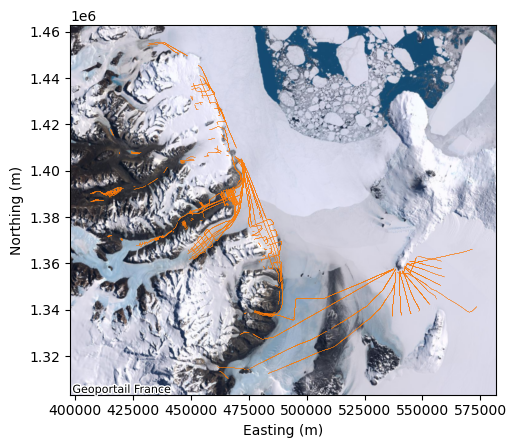

In [34]:
fig, ax = plt.subplots(1,1)
plt.scatter(data_file.UTMX, data_file.UTMY, s=0.005, c='tab:orange', edgecolors=None,linewidths=0.25)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)');
ctx.add_basemap(ax, source=ctx.providers.GeoportailFrance.orthos, zoom=8, crs=32758)
if savefig:
    plt.savefig('survey.eps', format='eps')

In [35]:
# Look at a single station (not all stations have lm/hm data)
line_no = 21415
line_grouping = data_file.groupby('LINE_NO')
line = line_grouping.get_group(line_no)

# get line data and group high moment (2)
hm_line = line.groupby('SEGMENT').get_group(2)

In [36]:
# get high moment data
hm_data = hm_line[data_keys]

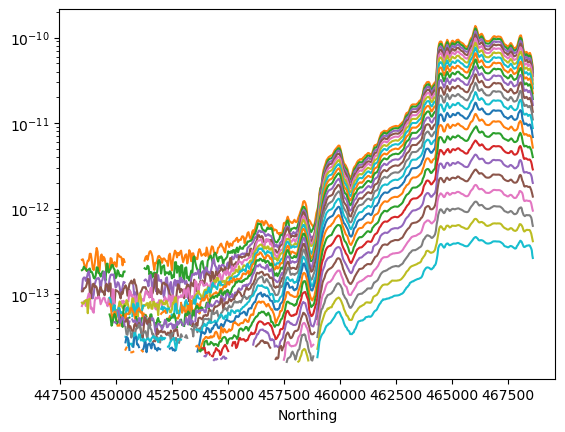

In [37]:
plt.semilogy(hm_line.UTMX, hm_data)
plt.xlabel('Northing');

In [38]:
# select a single sounding along the line, and grab all of the data associated with that station
station_num = 29328
station = line[line.RECORD==station_num]

station_hm = hm_line[hm_line.RECORD==station_num]
station_hm_data = station_hm[data_keys].to_numpy().flatten()
station_hm_std = station_hm[std_keys].to_numpy().flatten()


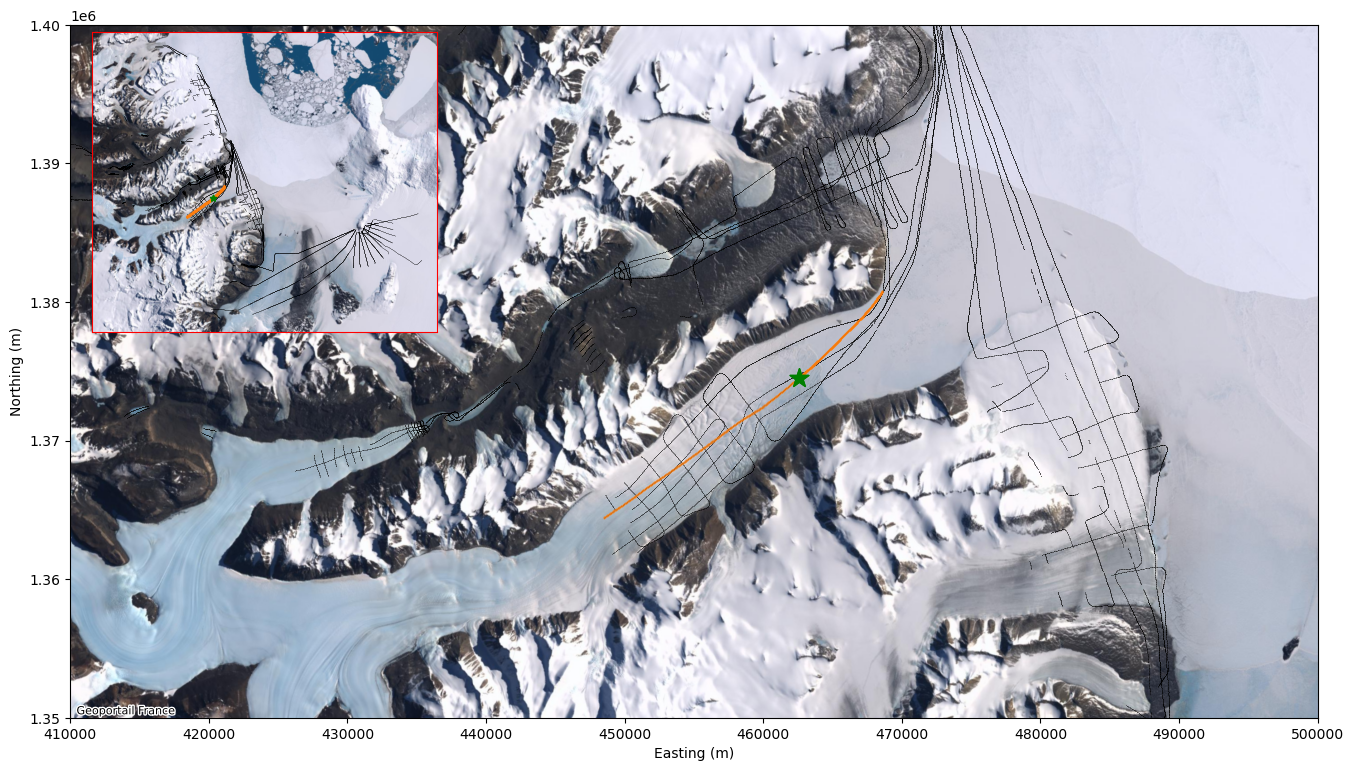

In [95]:
# figure of survey area highlighting the line and sounding
fig, ax = plt.subplots(1,1,figsize=(18,9))
plt.scatter(data_file.UTMX, data_file.UTMY, s=0.05, c='k', edgecolors=None,linewidths=0.25)
plt.scatter(line.UTMX, line.UTMY, s=0.1,c='tab:orange')
plt.scatter(station.UTMX, station.UTMY, s=200, marker='*',c='g')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

ax.set_ylim(1.35e6, 1.4e6)
ax.set_xlim(410000, 500000)
ctx.add_basemap(ax, source=ctx.providers.GeoportailFrance.orthos, zoom=10, crs=32758)

# add thumbnail to corner of plot to show where the data is
thumbnail_ax = inset_axes(ax, width="30%", height=3, loc='upper left')

# set extent of greenland for thumbnail axis in EPSG:3413

thumbnail_ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
for spine in ['bottom', 'top', 'right', 'left']:
    thumbnail_ax.spines[spine].set_color('red')

c = thumbnail_ax.scatter(data_file.UTMX, data_file.UTMY, s=0.01,c='k',linewidths=0.05,edgecolors=None)

thumbnail_ax.scatter(line.UTMX, line.UTMY, s=0.1,c='tab:orange')

thumbnail_ax.scatter(station.UTMX, station.UTMY, s=20, marker='*',c='g')
# set lower resolution background map for zoomed out plot of greenland
ctx.add_basemap(thumbnail_ax,  source=ctx.providers.GeoportailFrance.orthos, zoom=8, crs=32758, attribution=False)

if savefig:
    plt.savefig('survey_zoom.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


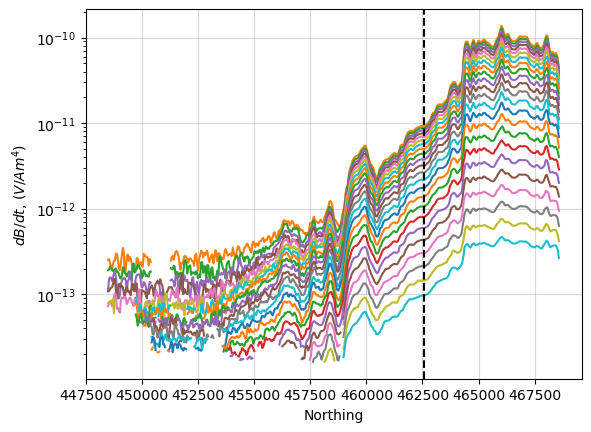

In [90]:
# plot sounding relative to the line
plt.semilogy(hm_line.UTMX, hm_data)
plt.axvline(station.UTMX.iloc[0],c='k',linestyle='--')
plt.ylabel('$dB/dt$, $(V/Am^4)$');
plt.xlabel('Northing');
plt.grid(alpha=0.5)

if savefig:
    plt.savefig('line_data.eps', format='eps')

[-1.26670000e-02 -1.26127852e-02 -1.22487357e-02 -1.19067267e-02
 -1.08915933e-02 -8.86157986e-03 -6.31272612e-03 -3.77501934e-03
 -1.23736323e-03  2.23935671e-06  4.22528897e-05  8.48604553e-05
  1.26729113e-04  1.68960891e-04  2.11572679e-04  2.50468813e-04
  2.54252024e-04  2.58246351e-04  1.26670000e-02]


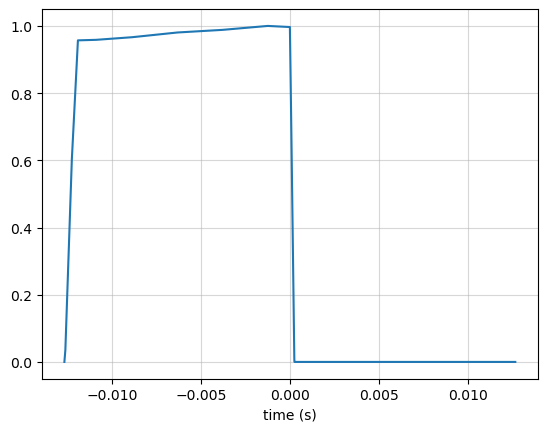

In [41]:
# High moment wave form retrieved from SkyTEM Hawkes Bay report. (!) Potentially need to change times to match those given in the antaem report. (!)

# high moment time array in seconds
hm_wave_time_Hawkes = np.array(   
    [  
        -5.0000E-03,
        -4.9786E-03,
        -4.8349E-03,
        -4.6999E-03,
        -4.2992E-03,
        -3.4979E-03,
        -2.4918E-03,
        -1.4901E-03,
        -4.8842E-04,
        2.6518E-06 ,
        5.0035E-05 ,
        1.0049E-04 ,
        1.5007E-04 ,
        2.0008E-04 ,
        2.5054E-04 ,
        2.9660E-04 ,
        3.0108E-04 ,
        3.0581E-04 ,
        1.5000E-002,
    ]
)
# normalized high moment amplitude array 
hm_wave_form = np.array(    
    [  
        0.0000E+00,
        3.5156E-02,
        6.0234E-01,
        9.5703E-01,
        9.5859E-01,
        9.6641E-01,
        9.8047E-01,
        9.8828E-01,
        1.0000E+00,
        9.9670E-01,
        8.4862E-01,
        6.8337E-01,
        5.1661E-01,
        3.4524E-01,
        1.7057E-01,
        1.2613E-02,
        3.8707E-03,
        0.0000E+00,
        0.0000E+000
    ]
)


# Change wave to antaem report specifications
tx_on_time_hm = 4.0E-3
tx_on_norm = hm_wave_time_Hawkes[0:9]/hm_wave_time_Hawkes[0]


tx_off_time_hm = 12.667E-3
tx_off_norm = hm_wave_time_Hawkes[9:]/hm_wave_time_Hawkes[-1] 

hm_wave_time = np.concatenate((-tx_on_norm*tx_off_time_hm,tx_off_norm*tx_off_time_hm))
# hm_wave_time -= hm_wave_time[-2]

plt.plot(hm_wave_time,hm_wave_form)
print(hm_wave_time)
plt.grid(alpha=0.5)
plt.xlabel("time (s)")

if savefig:
    plt.savefig('hm_wave.eps', format='eps')

In [42]:
# gate timings in seconds
gate_times = np.array(
    [
        3.3230E-5,
        4.2220E-5,
        5.3720E-5,
        6.8220E-5,
        8.6220E-5,
        1.0870E-4,
        1.3670E-4,
        1.7220E-4,
        2.1770E-4,
        2.7470E-4,
        3.4670E-4,
        4.1840E-4,
        4.3640E-4,
        4.3770E-4,
        4.5890E-4,
        4.8690E-4,
        5.2240E-4,
        5.5170E-4,
        5.6790E-4,
        6.2490E-4,
        6.9570E-4,
        6.9690E-4,
        7.8790E-4,
        8.7720E-4,
        9.0190E-4,
        1.0460E-3,
        1.1060E-3,
        1.2270E-3,
        1.3940E-3,
        1.4560E-3,
        1.7440E-3,
        2.1080E-3, 
        2.5670E-3,
        3.1450E-3,
        3.8640E-3,
        4.7440E-3,
        5.8210E-3,
        7.1390E-3,
        8.7530E-3,
        1.0730E-2,
    ]
)

In [43]:
# process out nan values
hm_good_data = ~np.isnan(station_hm_data)

hm_times = gate_times[hm_good_data]

station_hm_data = station_hm_data[hm_good_data]
station_hm_std = station_hm_std[hm_good_data]

# reset counts
n_hm_gates = len(hm_times)


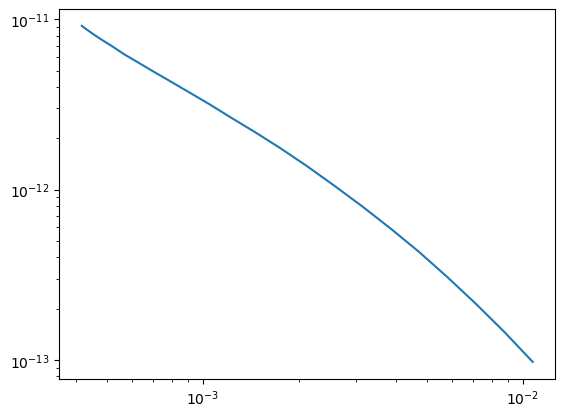

In [44]:
# plot decay curves
plt.loglog(hm_times, station_hm_data)

## Survey set-up
-----

In [45]:
# geometry of device from antaem readme [x, y, z] (m)
TxLoopPoints = np.array(
    [
        [-12.64, -2.10, 0],
        [-6.14,  -8.58, 0],
        [ 6.14,  -8.58, 0],
        [ 11.41, -3.31, 0],
        [ 11.41,  3.31, 0],
        [ 6.14,   8.58, 0],
        [-6.14,   8.58, 0],
        [-12.64,  2.10, 0]
    ]
)

RxZ = np.array([-13.25, 0.00, 2.0])  # [x, y, -z] (m) flip signs in z for simpeg/positive upwards

tx_area = 342 # m^2

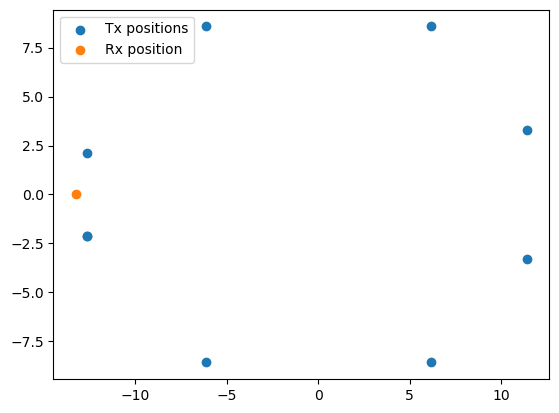

In [46]:
# add another row because we will need to close the transmitter loop.
tx_shape = np.vstack([TxLoopPoints,TxLoopPoints[0]])

rx_offset = RxZ

plt.scatter(*tx_shape[:, :-1].T, label='Tx positions')
plt.scatter(*rx_offset[:-1], label='Rx position')
plt.legend()

In [47]:
# convert to UTM  
tx_loc = tx_shape + [station.UTMX.iloc[0], station.UTMY.iloc[0], station.ALT.iloc[0]]
rx_loc = rx_offset + [station.UTMX.iloc[0], station.UTMY.iloc[0], station.ALT.iloc[0]]


In [48]:
# High moment survey input:
rx_hm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, hm_times, orientation='z'
)

hm_wave = tdem.sources.PiecewiseLinearWaveform(hm_wave_time, hm_wave_form)

src_hm = tdem.sources.LineCurrent(rx_hm, tx_loc, waveform=hm_wave)

In [49]:
# survey with only high moment as source
srv = tdem.Survey([src_hm])

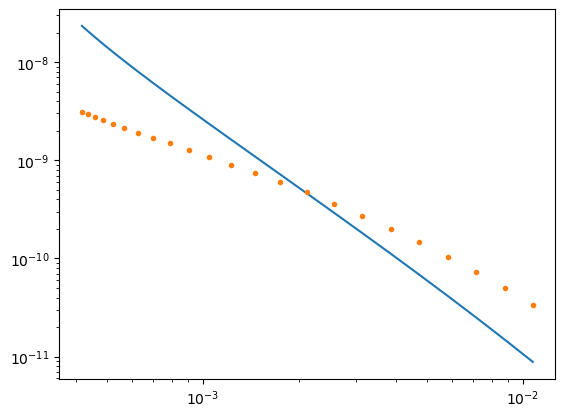

In [50]:
#first a simple test
thicknesses = []
conductivities = [1E-1]

sim = tdem.Simulation1DLayered(srv, sigma=conductivities, thicknesses=thicknesses)

pre = -sim.dpred(None)


plt.loglog(hm_times, pre)
plt.loglog(hm_times, station_hm_data*tx_area, color='C1', marker='.', linestyle='')

## Halfspace inversion set-up
-----

In [51]:
from SimPEG import maps
from SimPEG import data
from SimPEG.data_misfit import L2DataMisfit
from SimPEG import optimization
from SimPEG import regularization, inverse_problem
from SimPEG import inversion
from SimPEG import directives

In [52]:
dobs = -tx_area * np.r_[station_hm_data]

rel_err = np.r_[station_hm_std]

data_container = data.Data(srv, dobs=dobs, relative_error=rel_err)
data_container.nD

23

In [53]:
# invert for best fitting half-space
exp_map = maps.ExpMap()
sim_inv1 = tdem.Simulation1DLayered(srv, sigmaMap=exp_map)
sim_inv1.model = np.log(np.r_[1E-3])

In [54]:
# define objective function to be minimized
phi_d_1 = L2DataMisfit(data=data_container, simulation=sim_inv1)

m_0 = np.log(1E-2)  # sigma = 1E-2 S/m

In [55]:
minimizer = opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

In [56]:
empty_reg = regularization.Smallness(discretize.TensorMesh([1]))
# note we needed to pass a mesh that had a single cell
# in it because our model has 1 value.

In [57]:
# set-up minimizer for only the data misfit term (\beta=0)
inv_prob_1 = inverse_problem.BaseInvProblem(
    phi_d_1, reg=empty_reg, opt=minimizer, beta=0.0
)


In [58]:
inv1 = inversion.BaseInversion(inv_prob_1, [])

In [59]:
# Run inversion
recovered_model = inv1.run(m_0)

SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  8.30e+03  0.00e+00  8.30e+03    3.68e+03      0              
   1  0.00e+00  7.09e+03  3.33e-01  7.09e+03    4.17e+03      0              
   2  0.00e+00  6.71e+03  2.06e-01  6.71e+03    4.33e+02      0              
   3  0.00e+00  6.71e+03  1.90e-01  6.71e+03    2.60e+01      0   Skip BFGS  
   4  0.00e+00  6.71e+03  1.89e-01  6.71e+03    1.32e+00      0   Skip BFGS  
   5  0.00e+00  6.71e+03  1.89e-01  6.71e+03  

In [60]:
# Best fitting half-space
data_pre = sim_inv1.make_synthetic_data(recovered_model)
background_model = recovered_model[0] 
sim_inv1.sigmaMap * recovered_model

array([0.01847851])

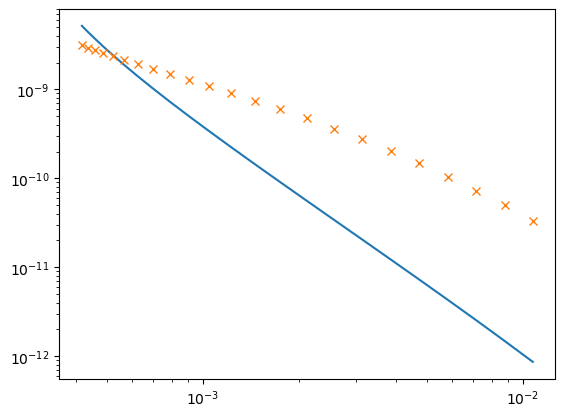

In [61]:
# plot best fit
plt.loglog(hm_times, -data_pre[src_hm, rx_hm])
    
plt.loglog(hm_times, -data_container[src_hm, rx_hm], color='C1', marker='x', linestyle="")

## Multi-layer inversion set-up
-----

In [62]:
# load in inversion file
inv_directory = '../usapdc_601373/SkyTEM2018_inv.xyz'
inv_file = pd.read_csv(inv_directory, skiprows=7, sep='\s+', escapechar='/')

# trim white space from first column
inv_file.columns = inv_file.columns.str.strip()

# print out dataframe
inv_file

,LINE_NO,UTMX,UTMY,RECORD,ELEVATION,RHO_I_1,RHO_I_2,RHO_I_3,RHO_I_4,RHO_I_5,...,THK_21,THK_22,THK_23,THK_24,THK_25,THK_26,THK_27,THK_28,THK_29,DOI_STANDARD
0,1101,541450.6,1356342.9,9,-53.5,119.2000,119.2000,117.2000,94.7100,55.1300,...,22.58,24.62,26.84,29.27,31.92,34.8,37.95,41.38,45.12,106.456
1,1101,541485.6,1356349.6,10,-53.6,52.4300,51.9500,2.1830,0.3990,0.6331,...,22.58,24.62,26.84,29.27,31.92,34.8,37.95,41.38,45.12,89.790
2,1101,541520.3,1356359.7,11,-53.5,9.2660,8.8630,0.4957,0.4961,0.5835,...,22.58,24.62,26.84,29.27,31.92,34.8,37.95,41.38,45.12,85.994
3,1101,541553.9,1356373.7,12,-53.5,6.7610,6.0510,0.4192,0.5510,0.5834,...,22.58,24.62,26.84,29.27,31.92,34.8,37.95,41.38,45.12,85.393
4,1101,541585.1,1356391.4,13,-53.5,6.7590,6.0490,0.4182,0.5508,0.5507,...,22.58,24.62,26.84,29.27,31.92,34.8,37.95,41.38,45.12,85.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40317,28030,471509.7,1405087.0,40326,-53.5,1.0010,1.2750,1.2740,1.3570,2.0220,...,22.58,24.62,26.84,29.27,31.92,34.8,37.95,41.38,45.12,61.975
40318,28030,471493.7,1405134.0,40327,-53.4,0.5438,0.3618,1.0710,1.3450,2.1150,...,22.58,24.62,26.84,29.27,31.92,34.8,37.95,41.38,45.12,69.793
40319,28030,471477.0,1405180.8,40328,-53.6,3.0870,0.2800,0.3477,1.0670,2.1160,...,22.58,24.62,26.84,29.27,31.92,34.8,37.95,41.38,45.12,61.633
40320,28030,471458.5,1405228.2,40329,-53.5,3.1410,0.2593,0.3149,0.5153,1.4880,...,22.58,24.62,26.84,29.27,31.92,34.8,37.95,41.38,45.12,59.110


In [63]:
# Extract inverted layer thickness
inv_thicknesses = inv_file[inv_file.keys()[35:-1]].to_numpy()[0]
inv_thicknesses

array([ 4.   ,  4.362,  4.756,  5.186,  5.654,  6.165,  6.723,  7.33 ,
        7.993,  8.715,  9.503, 10.36 , 11.3  , 12.32 , 13.43 , 14.65 ,
       15.97 , 17.42 , 18.99 , 20.71 , 22.58 , 24.62 , 26.84 , 29.27 ,
       31.92 , 34.8  , 37.95 , 41.38 , 45.12 ])

In [64]:
# Define number of layers
n_layers = 30
wire_map = maps.Wires(('sigma',n_layers), ('thicknesses', n_layers-1))

sigma_map = exp_map * wire_map.sigma
thick_map = exp_map * wire_map.thicknesses


# let's use the best fitting half-space as our initial model
m_sigma_0_2 = np.full(n_layers, recovered_model[0])  # Already in log-space
m_h_0_2 = np.log(np.full(n_layers-1, 10))
m_0_2 = np.r_[m_sigma_0_2, m_h_0_2]
sim_inv2 = tdem.Simulation1DLayered(srv, sigmaMap=sigma_map, thicknessesMap=thick_map)
sim_inv2.model = m_0_2

In [65]:
# Define mesh using inversion thicknesses
mesh = discretize.TensorMesh([(np.r_[inv_thicknesses])], "0")
mesh

TensorMesh: 29 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     29          0.00        500.02      4.00     45.12    1.09

In [66]:
mesh.h

(array([ 4.   ,  4.362,  4.756,  5.186,  5.654,  6.165,  6.723,  7.33 ,
         7.993,  8.715,  9.503, 10.36 , 11.3  , 12.32 , 13.43 , 14.65 ,
        15.97 , 17.42 , 18.99 , 20.71 , 22.58 , 24.62 , 26.84 , 29.27 ,
        31.92 , 34.8  , 37.95 , 41.38 , 45.12 ]),)

In [67]:
mesh.nodes

array([  0.   ,   4.   ,   8.362,  13.118,  18.304,  23.958,  30.123,
        36.846,  44.176,  52.169,  60.884,  70.387,  80.747,  92.047,
       104.367, 117.797, 132.447, 148.417, 165.837, 184.827, 205.537,
       228.117, 252.737, 279.577, 308.847, 340.767, 375.567, 413.517,
       454.897, 500.017])

In [68]:
alpha_s = 1e-10
# alpha_s = 1/mesh.h[0].mean()**2
alpha_z = 1

reg_s = regularization.Smallness(mesh, reference_model=background_model)
reg_z = regularization.SmoothnessFirstOrder(mesh, orientation="x") # x is first dimension in Simpeg

reg = alpha_s * reg_s + alpha_z * reg_z 

In [69]:
# inversion set-up
sim_reg = tdem.Simulation1DLayered(srv, sigmaMap=exp_map, thicknesses=mesh.h[0][:-1])

phi_d_reg = L2DataMisfit(data=data_container, simulation=sim_reg)

m_0_reg = np.full(mesh.n_cells, background_model)

beta0_ratio = 1e2
beta_estimate = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)

beta_cooler = directives.BetaSchedule(coolingFactor=5, coolingRate=2)
save_dict = directives.SaveOutputDictEveryIteration()

# create all of the same components of the inversion problem as before
minimizer_reg = opt = optimization.InexactGaussNewton(
    maxIter=20, maxIterLS=20, maxIterCG=100, tolCG=1e-5
)

# inv_prob_2 = inverse_problem.BaseInvProblem(
#     phi_d_reg, reg=reg, opt=minimizer_reg, beta=10000
# )

inv_prob_2 = inverse_problem.BaseInvProblem(
    phi_d_reg, reg=reg, opt=minimizer_reg
)

In [70]:
directives_list = [
    beta_estimate,
    beta_cooler,
    save_dict
]

inv4 = inversion.BaseInversion(inv_prob_2, directives_list)

# Run inversion
recovered_model_2 = inv4.run(m_0_reg)

SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.62e+05  6.71e+03  0.00e+00  6.71e+03    5.13e+02      0              
   1  1.62e+05  5.92e+03  2.09e-03  6.26e+03    1.93e+02      0              
   2  3.25e+04  5.70e+03  3.09e-03  5.80e+03    5.52e+02      0   Skip BFGS  
   3  3.25e+04  3.12e+03  4.52e-02  4.59e+03    6.79e+02      0              
   4  6.50e+03  3.11e+03  3.69e-02  3.35e+03    8.71e+02      0              
   5  6.50e+03  1.17e+03  1.35e-01  2.04e+03  

In [71]:
n_iter = save_dict.opt.iter
phi_ds = [save_dict.outDict[i]['phi_d'] for i in range(1, n_iter)]
phi_ms = [save_dict.outDict[i]['phi_m'] for i in range(1, n_iter)]
betas =  [save_dict.outDict[i]['beta'] for i in range(1, n_iter)]

(9, 8.861996168862852)

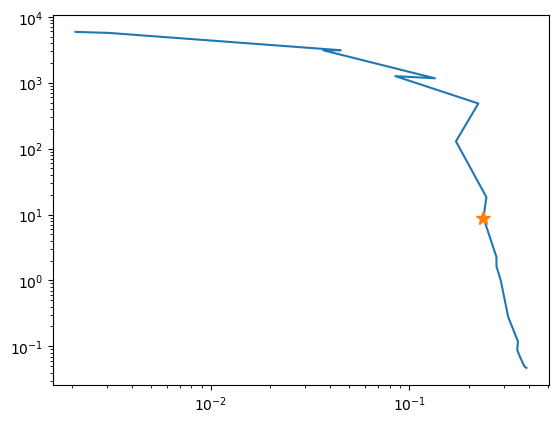

In [72]:
# this is an L-curvey plot
L_iter = (np.abs(np.asarray(phi_ds) < len(dobs))).argmax()+1
plt.loglog(phi_ms, phi_ds)
plt.loglog(phi_ms[L_iter], phi_ds[L_iter], marker='*', markersize=10)

L_iter,phi_ds[L_iter]

In [73]:
# get antaem inversion data for comparison
inv_line_grouping = inv_file.groupby('LINE_NO')
inv_line = inv_line_grouping.get_group(line_no)

inv_station = inv_line[inv_line.RECORD==station_num]
rho_keys = inv_file.keys()[5:35]
inv_station_rho = inv_station[rho_keys].to_numpy().flatten()
inv_station

,LINE_NO,UTMX,UTMY,RECORD,ELEVATION,RHO_I_1,RHO_I_2,RHO_I_3,RHO_I_4,RHO_I_5,...,THK_21,THK_22,THK_23,THK_24,THK_25,THK_26,THK_27,THK_28,THK_29,DOI_STANDARD
29319,21415,462568.3,1374537.6,29328,-46.7,685.9,685.9,685.8,685.7,685.5,...,22.58,24.62,26.84,29.27,31.92,34.8,37.95,41.38,45.12,138.394


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


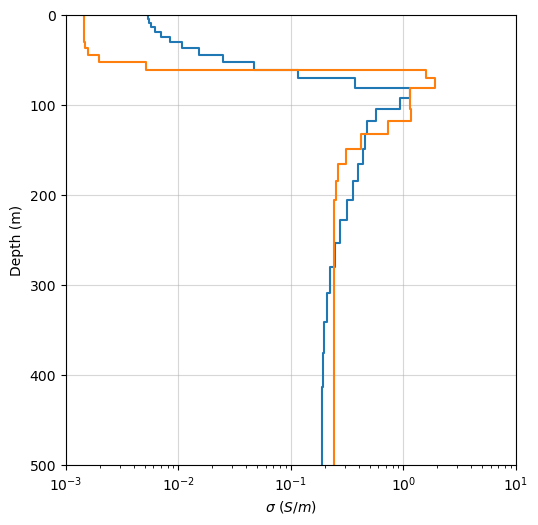

In [96]:
# plot model

m_final = save_dict.outDict[L_iter]['m']
d_final = sim_reg.make_synthetic_data(m_final)
ax = plot_1d_layer_model(sim_reg.thicknesses, exp_map * m_final)
plot_1d_layer_model(inv_thicknesses, 1/inv_station_rho, ax=ax)
ax.set_ylim([500, 0])
ax.set_xlim([1E-3, 1E1])
ax.set_xlabel("$\sigma$ ($S/m$)")
plt.grid(alpha=0.5)
if savefig:
    plt.savefig('1d_model_sigma.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


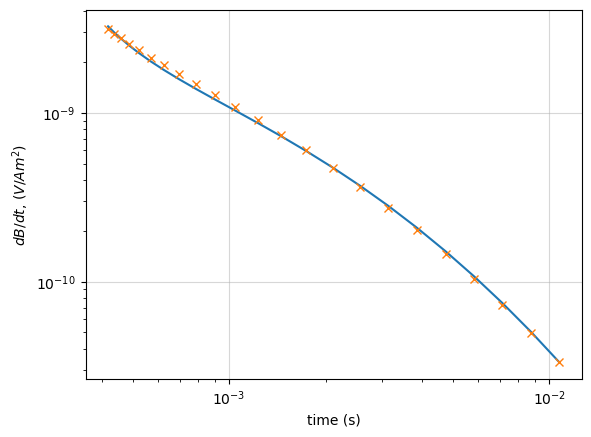

In [91]:
# plot best fit
plt.loglog(hm_times, -d_final[src_hm, rx_hm])
    
plt.loglog(hm_times, -data_container[src_hm, rx_hm], color='C1', marker='x', linestyle="")

plt.xlabel("time (s)")
plt.ylabel("$dB/dt$, $(V/Am^2)$")
plt.grid(alpha=0.5)

if savefig:
    plt.savefig('1d_model_data.eps', format='eps')

In [76]:
rel_diff = np.abs((data_container.dobs - d_final.dclean)/data_container.dobs)
rel_diff.mean()

0.0327466024899425

In [77]:
n_iter

20

In [78]:
save_dict.outDict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [79]:
(np.abs(np.asarray(phi_ds) < 0)).argmax() +1

1